# We try to reproduce google's [deepdream](https://github.com/google/deepdream) with tensorflow. the original work was implemented with caffe.

# Instead of caffe's inception model, we use the pre-trained model from tensorflow model zoo.
# Firstly let's download the model from http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz

In [1]:
import tensorflow as tf
from tensorflow.python.platform import gfile
def load_pb_model(pb_path):
    with tf.Graph().as_default() as graph:
        with gfile.FastGFile(model_path, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def)
            return graph

/Users/yzq/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
model_path = 'path/to/classify_image_graph_def.pb'
graph = load_pb_model(model_path)

# we steal this utility function from google's original work

In [3]:
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
from io import BytesIO

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

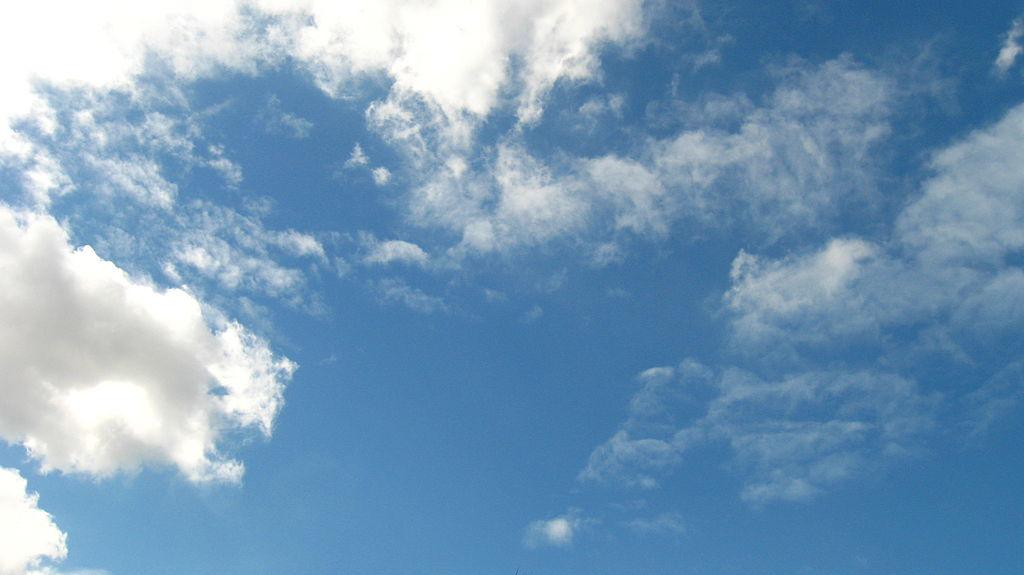

In [4]:
img = np.float32(PIL.Image.open('sky1024px.jpg'))
showarray(img)

# define preprocess and depreprocess funtions

In [5]:
def preprocess(a):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    # resize
    imr = PIL.Image.fromarray(a).resize((299,299), resample=PIL.Image.BILINEAR)
    pix = np.array(imr.getdata(), dtype=np.uint8).reshape((299,299,3))
    pix = np.reshape(pix, (1,299,299,3)).astype(np.float32)
    
    pix = pix/255
    pix = pix-0.5
    pix = pix*2
    return pix

def depreprocess(a, h, w):
    a = a[0]
    a = a/2
    a = a+0.5
    a = a*255
    
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    # resize
    imr = PIL.Image.fromarray(a).resize((w, h), resample=PIL.Image.BILINEAR)
    pix = np.array(imr.getdata(), dtype=np.uint8).reshape((h, w, 3))
    # pix = a
    return pix

# check correctness of depre/pre-process functions

(1, 299, 299, 3) (575, 1024, 3) 0.197934 152.731


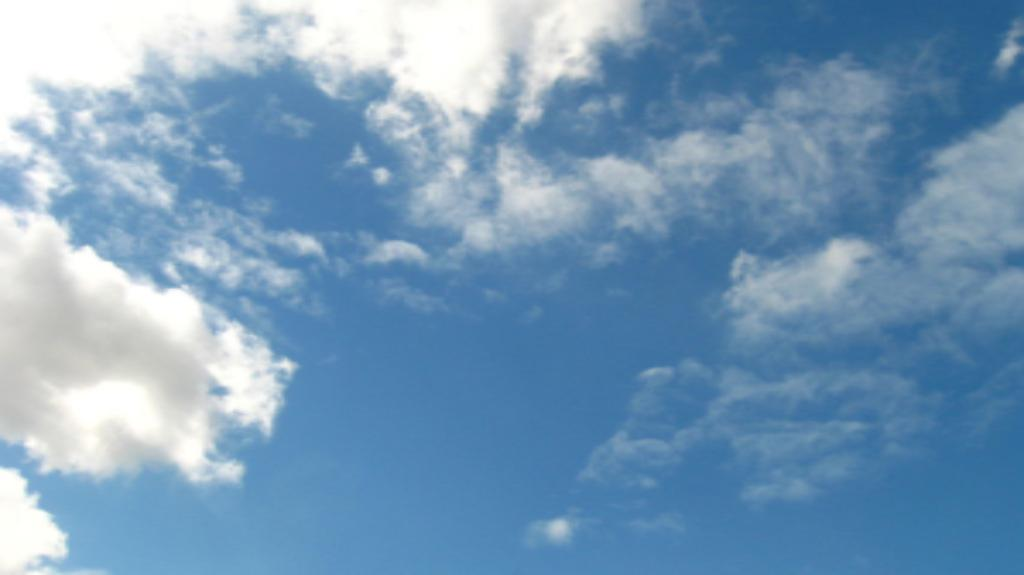

In [6]:
imr = preprocess(img)
print(imr.shape, img.shape, np.mean(imr), np.mean(img))
di = depreprocess(imr, img.shape[0], img.shape[1])
showarray(di)

In [7]:
def make_dream(img, step_size=1e-2, iter_num=100, feature_layer="import/mixed_4/join:0", show_every=100):
    pp = preprocess(img)
    input_layer = "import/Mul:0"

    with tf.Session(graph=graph) as sess:
        sess = tf.Session(graph=graph)
        feature = sess.graph.get_tensor_by_name(feature_layer)
        image = sess.graph.get_tensor_by_name(input_layer)

        target = tf.reduce_sum(feature*feature)
        grads = tf.gradients(target, image)[0]
        

        jitter = 32
        for i in range(iter_num):
            ox, oy = np.random.randint(-jitter, jitter+1, 2)
            pp[0] = np.roll(np.roll(pp[0], ox, -1), oy, -2) # apply jitter shift

            g = sess.run(grads, feed_dict={image:pp})
            pp += step_size/np.abs(g).mean()*g

            pp[0] = np.roll(np.roll(pp[0], -ox, -1), -oy, -2) # unshift image

            np.clip(pp, -1., 1.)

            out = depreprocess(pp, img.shape[0], img.shape[1])
            if (i+1)%show_every == 0:
                print("iteration: {}".format(i))
                showarray(out)
            # clear_output(wait=True)


iteration: 99


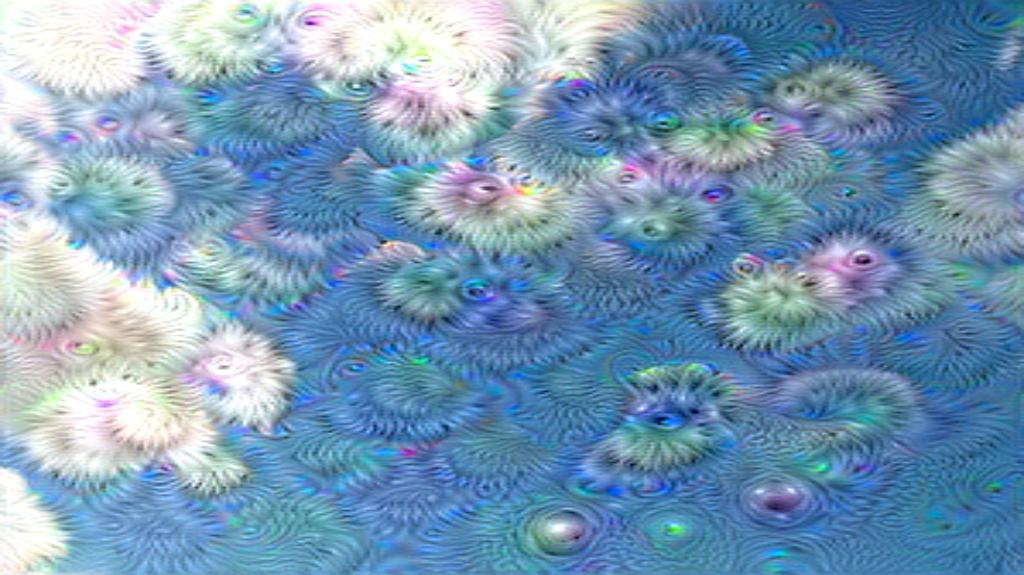

iteration: 199


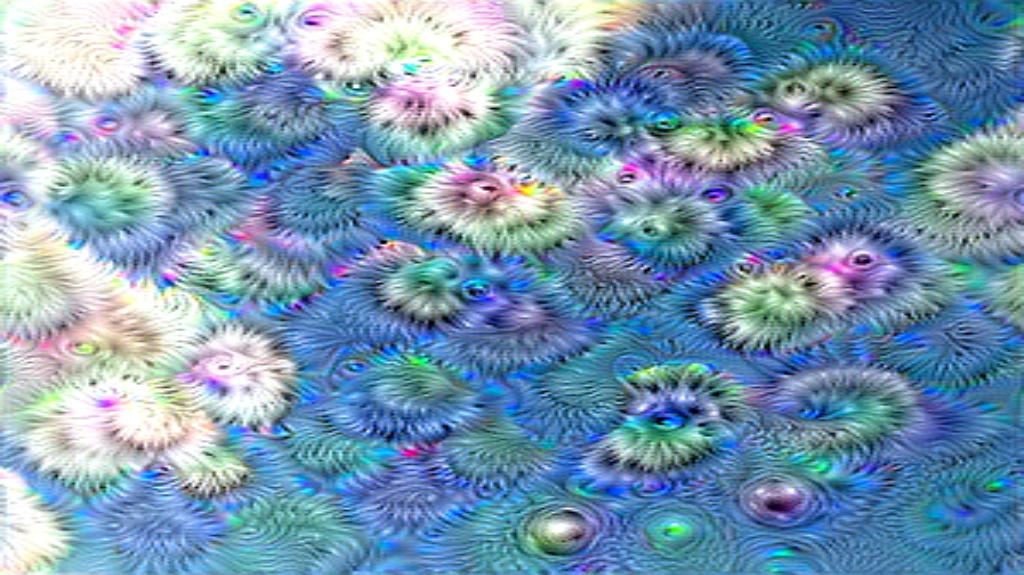

In [8]:
make_dream(img, step_size=1e-2, iter_num=200, feature_layer="import/mixed_4/join:0")

In [9]:
def make_guided_dream(img, guide_img, step_size=1e-3, iter_num=100, feature_layer="import/mixed_4/join:0", show_every=100):
    pp = preprocess(img)
    gp = preprocess(guide_img)
    
    input_layer = "import/Mul:0"
        
    with tf.Session(graph=graph) as sess:
        sess = tf.Session(graph=graph)
        feature = sess.graph.get_tensor_by_name(feature_layer)
        feature = tf.reshape(feature, (-1,))
        image = sess.graph.get_tensor_by_name(input_layer)
        
        guided_feature = sess.run(feature, feed_dict={image:gp})
        # guided_feature = np.reshape(guided_feature, (-1,))

        target = tf.reduce_sum(tf.multiply(guided_feature, feature))
        grads = tf.gradients(target, image)[0]

        jitter = 32
        for i in range(iter_num):
            ox, oy = np.random.randint(-jitter, jitter+1, 2)
            pp[0] = np.roll(np.roll(pp[0], ox, -1), oy, -2) # apply jitter shift

            g = sess.run(grads, feed_dict={image:pp})
            pp += step_size/np.abs(g).mean()*g

            pp[0] = np.roll(np.roll(pp[0], -ox, -1), -oy, -2) # unshift image

            np.clip(pp, -1., 1.)

            out = depreprocess(pp, img.shape[0], img.shape[1])
            if (i+1)%show_every == 0:
                print("iteration: {}".format(i))
                showarray(out)
            # clear_output(wait=True)

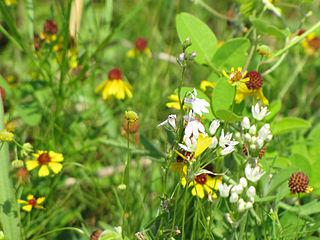

In [10]:
guide_img = np.float32(PIL.Image.open('flowers.jpg'))
showarray(guide_img)

iteration: 24


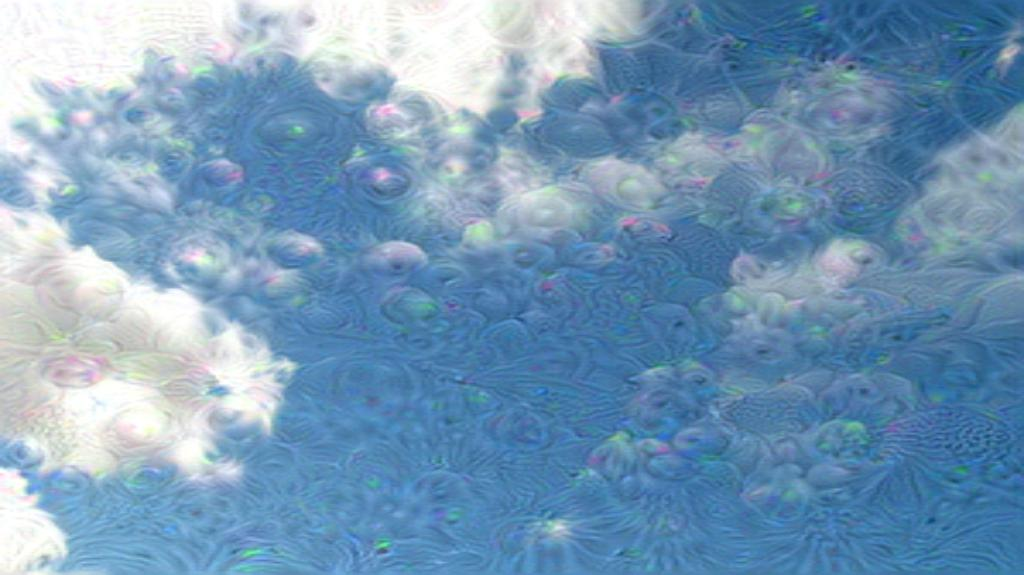

iteration: 49


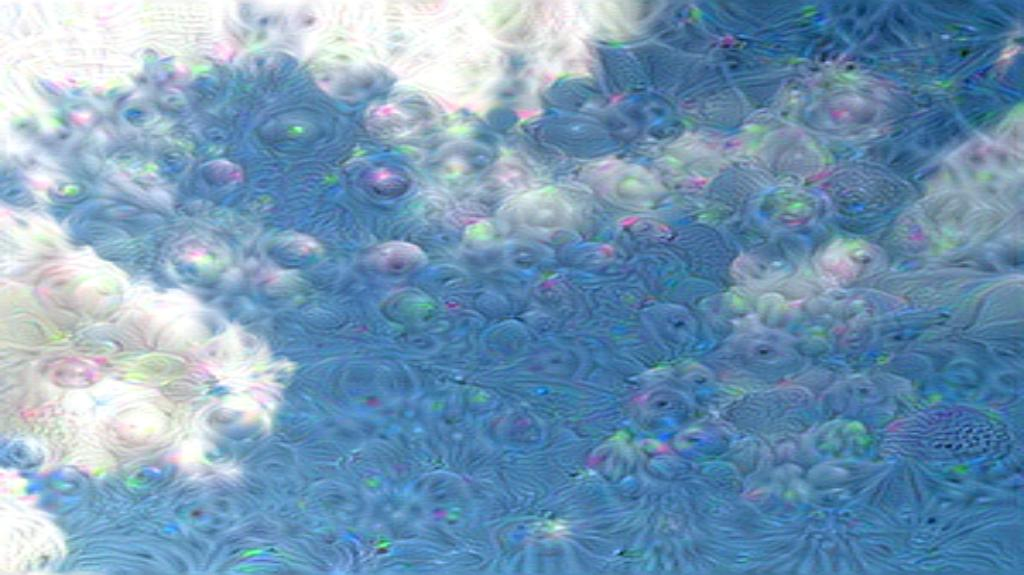

iteration: 74


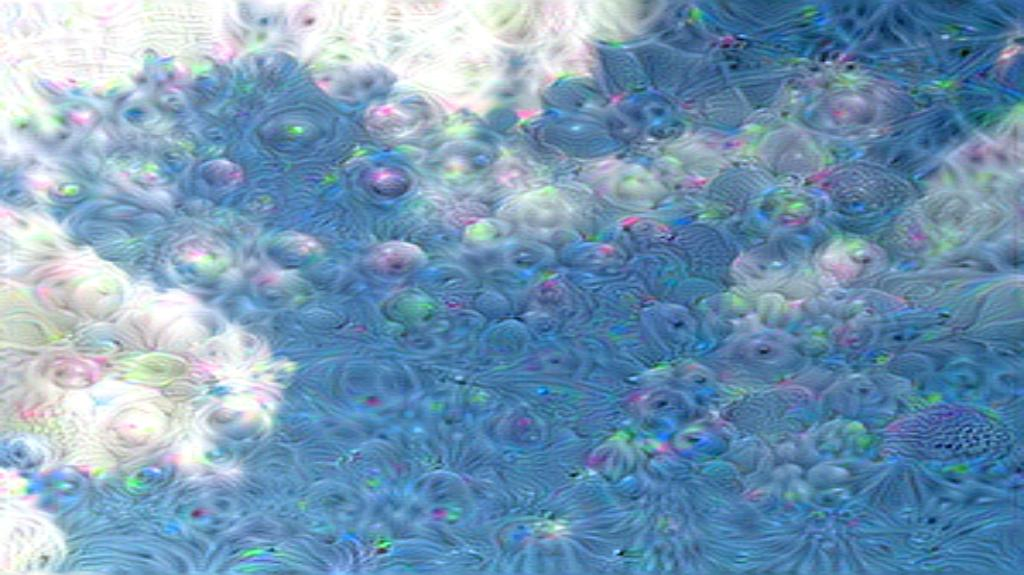

iteration: 99


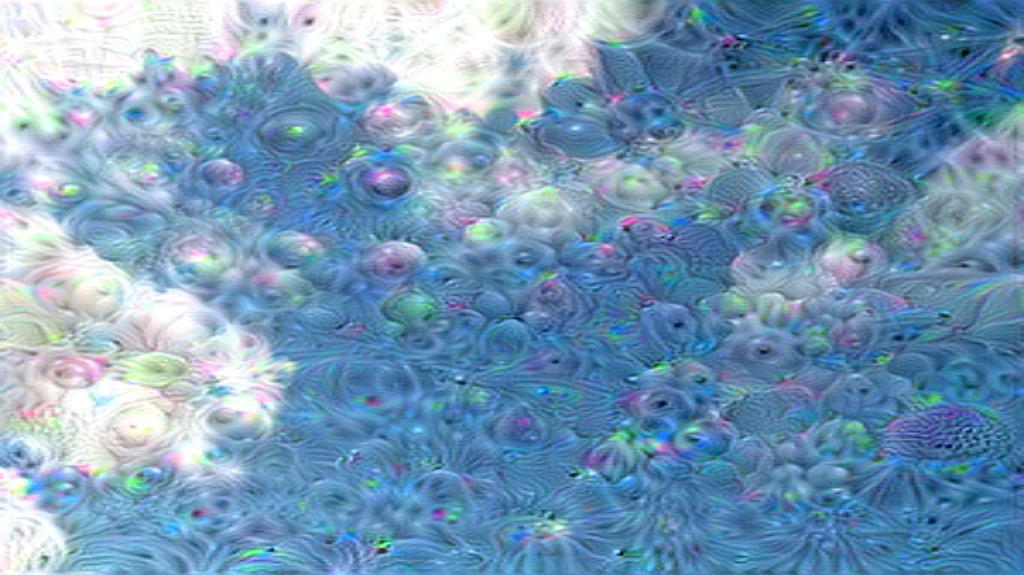

In [11]:
make_guided_dream(img, guide_img, step_size=1e-2, iter_num=100,
                  feature_layer="import/mixed_4/join:0", show_every=25)
